In [33]:
import pandas as pd
import numpy as np

import ta
import talib
from tech_indicators import stoch,stoch_signal

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [35]:
import random 
random.seed(999)
np.random.seed(999)

## Preparing Data 


In [4]:
fcpo_data_daily=pd.read_hdf('processed_dta.h5','fcpo_data_daily')
fcpo_data_hourly=pd.read_hdf('processed_dta.h5','fcpo_data_hourly')

In [36]:
fcpo_data_new=pd.read_hdf('processed_dta.h5','fcpo_data_new')

In [5]:
# infer whether the hour is a positive or negative price change
fcpo_data_hourly=fcpo_data_hourly.assign(positive_hour=(fcpo_data_hourly.apply(lambda x: 1 if x['Close'] > x['Open']*1.002 else 0 ,axis=1)),
                                        negative_hour=(fcpo_data_hourly.apply(lambda x: 1 if x['Open'] > x['Close']*1.002 else 0 ,axis=1)))

## Technical Indicators

* Momentum Indicators - Leading Indicators; Relative Change
 * MACD Diff - Crossover strategy
 * Relative Strength Index: An oscillator between 0 and 100; > 70-overbought, < 30-oversold
* Trend Indicators - Lagging Indicators
 * ADX - indicates the strength of trend ( < 20 no trend , > 20 trend)
 * Trend indicators based on close > sma(close,30)
 * Check for Trend to continue atleast 3 continuous periods
* Volume Indicators
 * Force index
 * On Balance Volume (OBV)
* Volatility Indicators
 * Bollinger Bands: Based on the moving average and n*standard deviations
 * Average True Range (ATR): Based on the current period's high, low and previous closing prices

Support and Resistance represents the lowest and highest values of the price in the given time period. It forms a basis for when to enter and exit positions and to be used together with other TA for devising features.

Infer the signals from the context

* Signal line crossovers ( switching between +/- values of macd diff)
* Center line crossovers ( switching between +/- values of macd)
* Divergence: Track the higher-highs/lower-lows of the indicators and price indexes to generate reversal flags

Momentum indicators work during sidwards moving market conditions, when the market is trending upwards/downwards a different strategy needs to be formulated.
* Trend look-back period should be atleast 2-3 times higher than the momentum look-back periods, to detect longer trend and then use the momentum for decisions
* Look for occassional oversold conditions in upward trend, or overbrought in downward trend


### Candle stick patterns

Candle stick patterns look at the Open-High-Low-Close values to identify whether there are any pre-defined observable patterns. Some common patterns include,

* Harami
* Doji
* Hanging man

In [7]:
def generate_tech_ind(fcpo_df):
    fcpo_df_tind=pd.DataFrame({
        'ema_slow_open':ta.trend.ema_slow(fcpo_df['Open'],n_slow=25).bfill(),
        'ema_fast_open':ta.trend.ema_fast(fcpo_df['Open'],n_fast=10).bfill(),
        'sma_slow_open': talib.SMA(fcpo_df['Open'],timeperiod=25).bfill(),
        'sma_fast_open': talib.SMA(fcpo_df['Open'],timeperiod=10).bfill(),
        'macd_open': ta.trend.macd(fcpo_df['Open']).bfill(),
        'macd_signal_open': ta.trend.macd_signal(fcpo_df['Open']).bfill(),
        'rsi_open':ta.momentum.rsi(fcpo_df['Open']).bfill(),
        'ema_slow_high':ta.trend.ema_slow(fcpo_df['High'],n_slow=25).bfill(),
        'ema_fast_high':ta.trend.ema_fast(fcpo_df['High'],n_fast=10).bfill(),
        'sma_slow_high': talib.SMA(fcpo_df['High'],timeperiod=25).bfill(),
        'sma_fast_high': talib.SMA(fcpo_df['High'],timeperiod=10).bfill(),
        'macd_high': ta.trend.macd(fcpo_df['High']).bfill(),
        'macd_signal_high': ta.trend.macd_signal(fcpo_df['High']).bfill(),
        'rsi_high':ta.momentum.rsi(fcpo_df['High']).bfill(),
        'ema_slow_low':ta.trend.ema_slow(fcpo_df['Low'],n_slow=25).bfill(),
        'ema_fast_low':ta.trend.ema_fast(fcpo_df['Low'],n_fast=10).bfill(),
        'sma_slow_low': talib.SMA(fcpo_df['Low'],timeperiod=25).bfill(),
        'sma_fast_low': talib.SMA(fcpo_df['Low'],timeperiod=10).bfill(),
        'macd_low': ta.trend.macd(fcpo_df['Low']).bfill(),
        'macd_signal_low': ta.trend.macd_signal(fcpo_df['Low']).bfill(),
        'rsi_low':ta.momentum.rsi(fcpo_df['Low']).bfill(),
        'ema_slow_close':ta.trend.ema_slow(fcpo_df['Close'],n_slow=25).bfill(),
        'ema_fast_close':ta.trend.ema_fast(fcpo_df['Close'],n_fast=10).bfill(),
        'sma_slow_close': talib.SMA(fcpo_df['Close'],timeperiod=25).bfill(),
        'sma_fast_close': talib.SMA(fcpo_df['Close'],timeperiod=10).bfill(),
        'macd_close': ta.trend.macd(fcpo_df['Close']).bfill(),
        'macd_signal_close': ta.trend.macd_signal(fcpo_df['Close']).bfill(),
        'rsi_close':ta.momentum.rsi(fcpo_df['Close']).bfill(),
        'stoch' : stoch(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'stoch_signal' : stoch_signal(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'rsi_close':ta.momentum.rsi(fcpo_df['Close']).bfill(),
        'adx': ta.trend.adx(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'atr': ta.volatility.average_true_range(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        #'find' : ta.volume.force_index(fcpo_df['Close'],fcpo_df['Volume']).bfill(),
        'eom': ta.volume.ease_of_movement(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close'],fcpo_df['Volume'],n=10,fillna=True).bfill()
       })
    return fcpo_df_tind

In [6]:
def generate_candlestick_ind(fcpo_df):
    fcpo_cdl_ind=pd.DataFrame({'cdl_rickshawman':talib.CDLRICKSHAWMAN(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']),
                  'cdl_longlegdoji':talib.CDLLONGLEGGEDDOJI(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']),
                  'cdl_harami': talib.CDLHARAMI(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']),
                  'cdl_spintop': talib.CDLSPINNINGTOP(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']),
                  'cdl_marubozu': talib.CDLMARUBOZU(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']),
                  'cdl_longline': talib.CDLLONGLINE(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']),
                  'cdl_hikkake': talib.CDLHIKKAKE(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']),
                  'cdl_highwave': talib.CDLHIGHWAVE(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']),
                  'cdl_engulfing': talib.CDLENGULFING(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']),
                  'cdl_doji': talib.CDLDOJI(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']),
                  'cdl_closingmarubozu': talib.CDLCLOSINGMARUBOZU(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']),
                  'cdl_belthold': talib.CDLBELTHOLD(fcpo_df['Open'],fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close'])
                   })
    return fcpo_cdl_ind

In [8]:
def generate_custom_ind(fcpo_data_daily,fcpo_data_hourly):
    # compute the number of day difference from previous trading day
    trading_day_gap=(pd.Series(fcpo_data_daily.index) - pd.Series(fcpo_data_daily.index).shift(1)).dt.days.bfill()
    trading_day_gap.name='tday_gap'
    day_of_week=pd.Series(fcpo_data_daily.index.date).apply(lambda x: x.weekday())
    day_of_week.name='day_of_week'
    fcpo_hourly_ind=fcpo_data_hourly.groupby(fcpo_data_hourly.index.date).agg({'positive_hour':'sum','negative_hour':'max'})
    ## features for the last hour of trading day
    fcpo_hourly_lasthour=fcpo_data_hourly[fcpo_data_hourly.index.hour==17].apply(lambda x: 1 if x['Close'] > x['Open']*1.002 else 0,axis=1)
    fcpo_hourly_lasthour.index=(fcpo_hourly_lasthour.index).map(lambda x: x.date)
    fcpo_hourly_ind=fcpo_hourly_ind.merge(pd.DataFrame(fcpo_hourly_lasthour),left_index=True,
                                        right_index=True,how='left').rename(columns={0:'last_hour_positive_ind'}).fillna(0)
    fcpo_daily_cind=pd.concat([trading_day_gap,day_of_week],axis=1).set_index(fcpo_data_daily.index).merge(fcpo_hourly_ind,
                                                                                           left_index=True,right_index=True)
    return fcpo_daily_cind
    

In [9]:
fcpo_daily_tind=generate_tech_ind(fcpo_data_daily[['Open','High','Low','Close','Volume']].shift(1))
fcpo_daily_cdlind=generate_candlestick_ind(fcpo_data_daily[['Open','High','Low','Close']].shift(1))

In [37]:
fcpo_new_tind=generate_tech_ind(fcpo_data_new[['Open','High','Low','Close','Volume']].shift(1))
fcpo_new_cdlind=generate_candlestick_ind(fcpo_data_new[['Open','High','Low','Close']].shift(1))

In [10]:
fcpo_daily_cind=generate_custom_ind(fcpo_data_daily,fcpo_data_hourly).shift(1).bfill()

In [38]:
## store the features in a hdf5 file
hdf_store=pd.HDFStore('processed_dta.h5')
hdf_store.put('fcpo_daily_cdlind',fcpo_daily_cdlind)
hdf_store.put('fcpo_daily_tind',fcpo_daily_tind)
hdf_store.put('fcpo_daily_cind',fcpo_daily_cind)
hdf_store.put('fcpo_new_tind',fcpo_new_tind)
hdf_store.put('fcpo_new_cdlind',fcpo_new_cdlind)
hdf_store.close()

### Momentum Indicators - MACD, Stoch, RSI

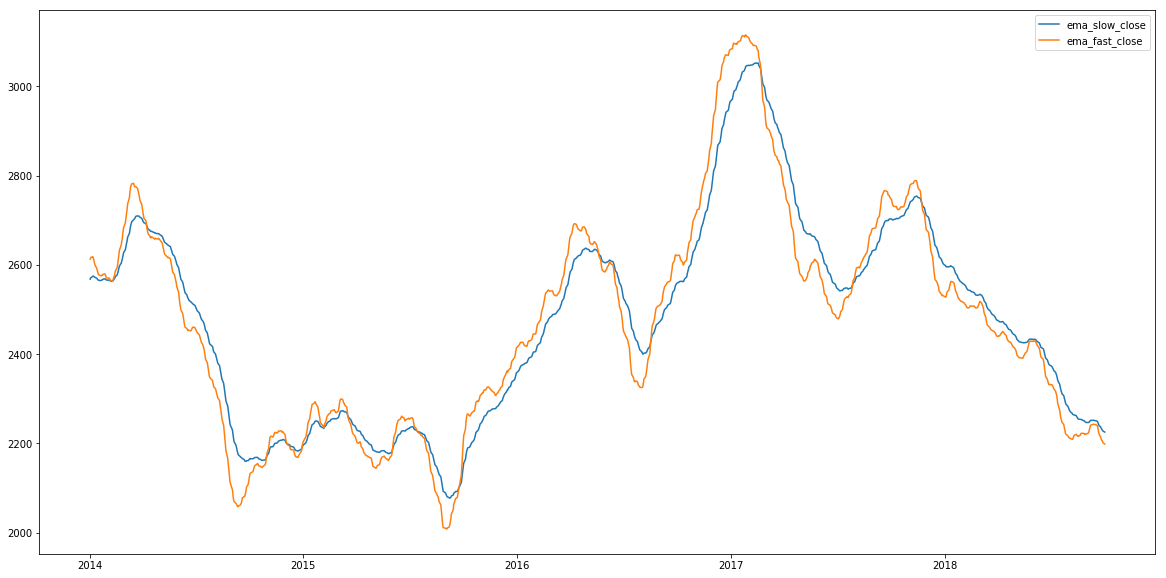

In [45]:
plt.figure(figsize=(20,10))
plt.plot(fcpo_new_tind['2014-01-01':'2018-10-01']['ema_slow_close'])
plt.plot(fcpo_new_tind['2014-01-01':'2018-10-01']['ema_fast_close'])
#plt.plot(fcpo_data_daily['2007-01-01':'2016-01-01']['Close'])
plt.legend()
plt.show()

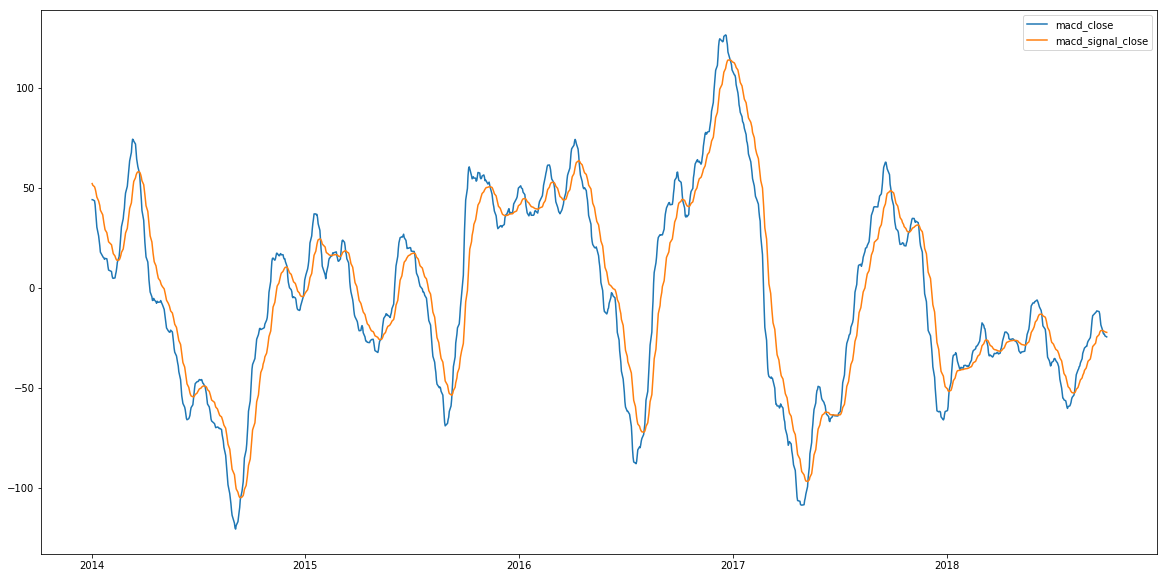

In [46]:
plt.figure(figsize=(20,10))
plt.plot(fcpo_new_tind['2014-01-01':'2018-10-01']['macd_close'])
plt.plot(fcpo_new_tind['2014-01-01':'2018-10-01']['macd_signal_close'])
plt.legend()
plt.show()

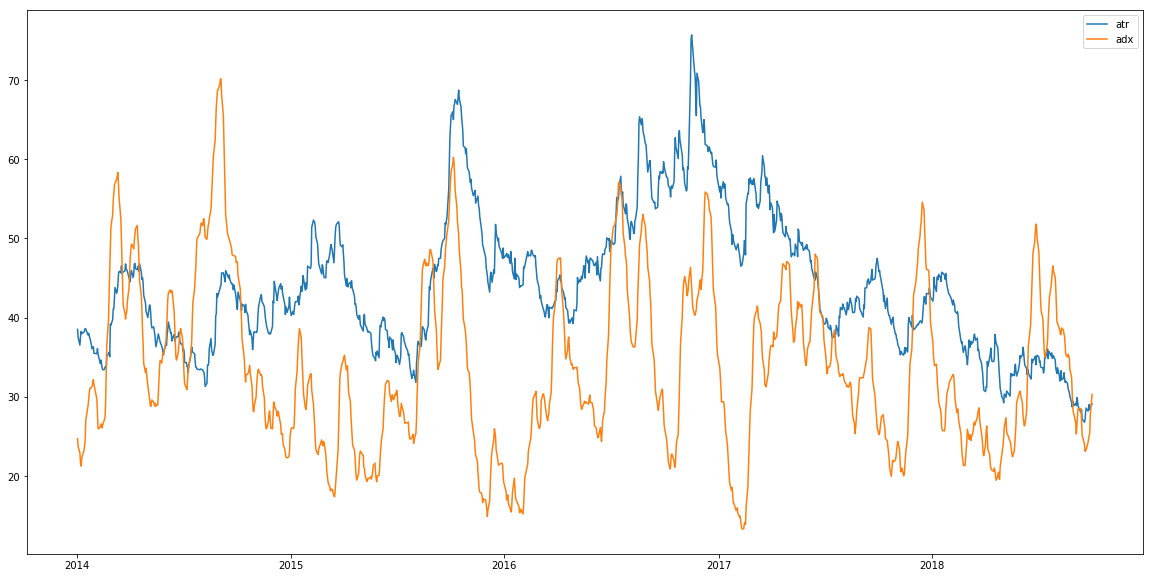

In [47]:
plt.figure(figsize=(20,10))
plt.plot(fcpo_new_tind['2014-01-01':'2018-10-01']['atr'])
plt.plot(fcpo_new_tind['2014-01-01':'2018-10-01']['adx'])
plt.legend()
plt.show()

## Representing data in Candle sticks format

In [22]:
selected_fcpo_data=fcpo_data_hourly['2015-01-01':'2017-01-01']

In [23]:
cndl_trace=go.Candlestick(x=selected_fcpo_data.index,
            open=selected_fcpo_data.Open,
            close=selected_fcpo_data.Close,
            high=selected_fcpo_data.High,
            low=selected_fcpo_data.Low)
iplot([cndl_trace])

In [24]:
cndl_trace=go.Bar(x=fcpo_daily_cdlind['2014-01-01':'2016-01-01'].index,
            y=fcpo_daily_cdlind['2014-01-01':'2016-01-01']['cdl_closingmarubozu'])
iplot([cndl_trace])

### FCPO Profit Indicators

In [49]:
fcpo_data_new['2011-01-01':'2017-01-01'].groupby(['lprofit_ind_2pct','sprofit_ind_2pct'])['Close'].count()

lprofit_ind_2pct  sprofit_ind_2pct
0                 0                   809
                  1                   344
1                 0                   314
                  1                     8
Name: Close, dtype: int64

In [50]:
fcpo_data_new['2017-01-01':'2018-10-01'].groupby(['lprofit_ind_2pct','sprofit_ind_2pct'])['Close'].count()

lprofit_ind_2pct  sprofit_ind_2pct
0                 0                   292
                  1                    77
1                 0                    55
Name: Close, dtype: int64